In [1]:
%matplotlib widget

from experiments import Experiment, _DefaultFloatLogSlider, _DefaultIntSlider

from translocation_models import TranslocationModel, \
    SC2R, SC2R2Loops, DefectiveSC2R, \
    DiscSpiral, DefectiveDiscSpiral

from ipywidgets import Widget, FloatLogSlider, IntSlider, \
    HBox, VBox, HTML, Output, Layout
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt


In [4]:
class SC2RDiscSpiralComparison(Experiment):
    def __init__(self):
        self._sc2r = SC2R()
        self._disc_spiral = DiscSpiral()
        super().__init__()

    def _construct_free_parameters(self) -> dict[str, Widget]:
        return {
            'atp_adp_ratio': _DefaultFloatLogSlider(
                value=1e2, min=0, max=4, readout_format='.1e',
                description="[ATP]/[ADP]:"),
            'equilibrium_atp_adp_ratio': _DefaultFloatLogSlider(
                value=1e-5, min=-7, max=-3, readout_format='.1e',
                description="([ATP]/[ADP])|eq.:"),
            'K_d_atp': _DefaultFloatLogSlider(
                value=0.1, description="K_d^ATP:"),
            'K_d_adp': _DefaultFloatLogSlider(description="K_d^ADP:"),
            'k_DT': _DefaultFloatLogSlider(description="k_DT:"),
            'k_h': _DefaultFloatLogSlider(description="k_h:"),
            'k_s': _DefaultFloatLogSlider(value=0.1, description="k_s:"),
            'k_up': _DefaultFloatLogSlider(description="k_↑:"),
            'n_protomers': _DefaultIntSlider(description="n_protomers:"),
            'k_extended_to_flat_up': _DefaultFloatLogSlider(description="k_⮫:"),
            'k_flat_to_extended_down': _DefaultFloatLogSlider(description="k_⮯:"),
            'k_flat_to_extended_up': _DefaultFloatLogSlider(description="k_⮭:"),
        }

    def _construct_constrained_parameters(self) -> dict[str, Widget]:
        return {
            'k_TD': HTML(description="k_TD:"),
            'k_down': HTML(description="k_↓:"),
            'k_h_bar': HTML(description="ꝁ_h:"),
            'k_flat_to_extended_down_bar': HTML(description="ꝁ_⮯:"),
            'k_extended_to_flat_down': HTML(description="k_⮩:"),
        }

    def _construct_gui(self) -> Widget:
        gui_plot = Output()
        gui_parameters = VBox([
            HTML(value="<h1>SC/2R and Disc-Spiral ATP consumption rate comparison</h1>"),

            HTML(value="<b>General Physical Parameters</b>"),
            HBox([self._free_parameters['atp_adp_ratio'],
                  HTML(value="ATP/ADP concentration ratio")]),
            HBox([self._free_parameters['equilibrium_atp_adp_ratio'],
                  HTML(value="Equilibrium ATP/ADP concentration ratio")]),
            HBox([self._free_parameters['K_d_atp'],
                  HTML(value="Protomer-ATP dissociation constant")]),
            HBox([self._free_parameters['K_d_adp'],
                  HTML(value="Protomer-ADP dissociation constant")]),
            HBox([self._free_parameters['k_DT'],
                  HTML(value="Effective ADP->ATP exchange rate")]),
            HBox([self._constrained_parameters['k_TD'],
                  HTML(value="Effective ATP->ADP exchange rate "
                       "(constrained by Protomer-ATP/ADP exchange model)")]),
            HBox([self._free_parameters['k_h'],
                  HTML(value="ATP Hydrolysis rate")]),
            HBox([self._free_parameters['k_s'],
                  HTML(value="ATP Synthesis rate")]),

            HTML(value="<b>SC2R Model Physical Parameters</b>"),
            HBox([self._free_parameters['k_up'],
                  HTML(value="Translocation up rate")]),
            HBox([self._constrained_parameters['k_down'],
                  HTML(value="Translocation down rate "
                       "(constrained by detailed balance)")]),

            HTML(value="<b>Disc-Spiral Model Physical Parameters</b>"),
            HBox([self._free_parameters['n_protomers'],
                  HTML(value="Number of protomers")]),
            HBox([self._constrained_parameters['k_h_bar'],
                  HTML(value="Effective ATP hydrolysis rate")]),
            HBox([self._free_parameters['k_extended_to_flat_up'],
                  HTML(value="Spiral->disc up translocation rate")]),
            HBox([self._free_parameters['k_flat_to_extended_down'],
                  HTML(value="Disc->spiral down translocation rate")]),
            HBox([self._constrained_parameters['k_flat_to_extended_down_bar'],
                  HTML(value="Effective disc->spiral down translocation rate")]),
            HBox([self._free_parameters['k_flat_to_extended_up'],
                  HTML(value="Disc->spiral up translocation rate")]),
            HBox([self._constrained_parameters['k_extended_to_flat_down'],
                  HTML(value="Spiral->disc down rate "
                       "(constrained by detailed balance)")]),
        ])

        gui = HBox([gui_plot, gui_parameters],
                   layout=Layout(align_items='center'))

        return gui

    def _run(self) -> None:
        # Update GUI<->Models
        models = [self._sc2r, self._disc_spiral]
        self._update_models_free_parameters(models, self._free_parameters)
        self._update_gui_constrained_parameters(models,
                                                self._constrained_parameters)

        for model in models:
            model.normalize_average_velocity(inplace=True)

        # For both model, we do few trajectories, compute analytical stats and
        # empirical stats, and then plot everything.

        n_steps = 100
        n_simulations = 3
        sc2r_trajectories = self._sc2r.gillespie(
            n_steps=n_steps,
            n_simulations=n_simulations,
            cumulative_sums='position')
        
        sc2r_analytical_position_stats = self._sc2r.analytical_attribute_stats(
            'position', sc2r_trajectories[0]['timestamp'])
        sc2r_empirical_position_stats = self._sc2r.empirical_attribute_stats(
            'position', n_steps=n_steps)
        disc_spiral_trajectories = self._disc_spiral.gillespie(
            n_steps=n_steps,
            n_simulations=n_simulations,
            cumulative_sums='position')
        disc_spiral_analytical_position_stats = \
            self._disc_spiral.analytical_attribute_stats(
                'position', disc_spiral_trajectories[0]['timestamp'])
        disc_spiral_empirical_position_stats = \
            self._disc_spiral.empirical_attribute_stats(
                'position', n_steps=n_steps)
        # We cut all data that exceed the minmax empirical stats timestamp
        # because empirical stats are the limiting factor
        max_timestamp = min(
            sc2r_empirical_position_stats['timestamp'].iat[-1],
            disc_spiral_empirical_position_stats['timestamp'].iat[-1])
        for trajectory in sc2r_trajectories + disc_spiral_trajectories:
            trajectory.drop(
                trajectory[trajectory['timestamp'] > max_timestamp].index,
                inplace=True)
        for empirical_stats in [
                sc2r_empirical_position_stats,
                disc_spiral_empirical_position_stats]:
            empirical_stats.drop(
                empirical_stats[
                    empirical_stats['timestamp'] > max_timestamp].index,
                inplace=True)
        for analytical_stats in [
                sc2r_analytical_position_stats,
                disc_spiral_analytical_position_stats]:
            analytical_stats.drop(
                analytical_stats[
                    analytical_stats['timestamp'] > max_timestamp].index,
                inplace=True)

        gui_plot = self._gui.children[0]
        with gui_plot:
            gui_plot.clear_output(wait=True)
            plt.close('SC2RDiscSpiralComparison')
            fig = plt.figure('SC2RDiscSpiralComparison')
            ax = fig.add_subplot(111)

            ax.fill_between(
                sc2r_analytical_position_stats['timestamp'],
                sc2r_analytical_position_stats['mean'] -
                sc2r_analytical_position_stats['std'],
                sc2r_analytical_position_stats['mean'] +
                sc2r_analytical_position_stats['std'],
                color='#DDAA33', alpha=0.2)
            print(sc2r_empirical_position_stats['timestamp'])
            print(sc2r_empirical_position_stats['mean'])
            plt.figure("test")
            plt.plot(sc2r_empirical_position_stats['timestamp'],
                     sc2r_empirical_position_stats['mean'])
            ax.plot(
                sc2r_empirical_position_stats['timestamp'],
                sc2r_empirical_position_stats['mean'],
                color='#DDAA33')


            ax.fill_between(
                disc_spiral_analytical_position_stats['timestamp'],
                disc_spiral_analytical_position_stats['mean'] -
                disc_spiral_analytical_position_stats['std'],
                disc_spiral_analytical_position_stats['mean'] +
                disc_spiral_analytical_position_stats['std'],
                color='#004488', alpha=0.2)
            plt.show()

In [5]:
experiment = SC2RDiscSpiralComparison()

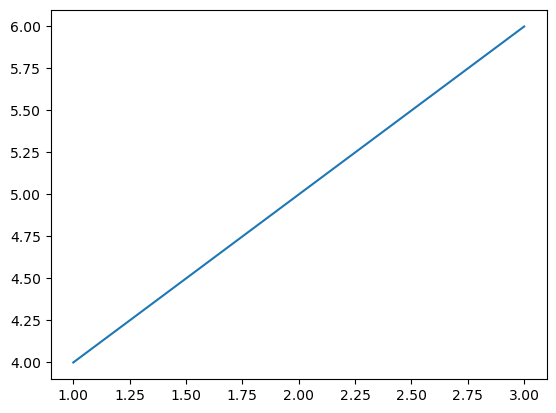

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data_frame = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
plt.plot(data_frame['a'], data_frame['b'])
plt.show()

Line graph: 


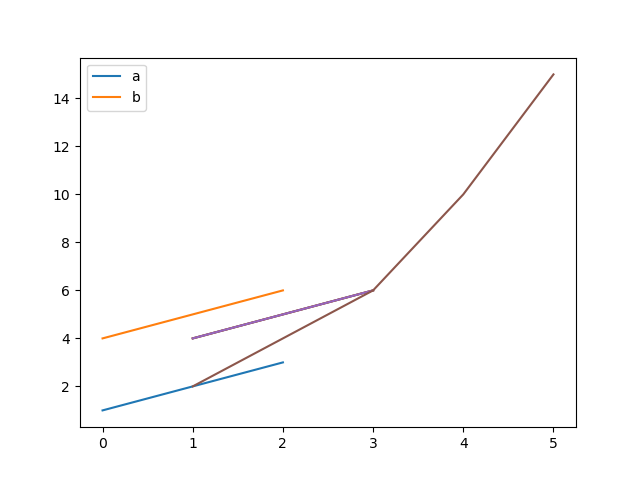

In [18]:
df = pd.DataFrame({ 
    'X': [1, 2, 3, 4, 5], 
    'Y': [2, 4, 6, 10, 15] 
}) 
  
# plotting a line graph 
print("Line graph: ") 
plt.plot(df["X"], df["Y"]) 
plt.show() 